# Hannah Zhao - Week 1 Basic DenseNet Model
## *building off of work from previous quarter*
#### changes include: filtering out images that are mostly white, replaced centercrop with padding + resizing, filtering and training by one type of stain, took at oversampling (not addressing class imbalance)
#### overall results:  shows once you stop addressing class imbalance, model collapses (pretty much predicting always the ambiguous label) --  planning to explore Multiple Instance Learning

In [63]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image

In [64]:
# Define local file paths

# Define your Desktop folder based on your OS; this uses the user's home directory.
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# Path to the filtered patches folder on your Desktop
filtered_patches_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "filtered_patches")

# Path to the CSV file inside Desktop/uni/STAT 390/Hannah Zhao
csv_file_path = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "case_grade_match.csv")

# Directory to store model checkpoints
checkpoint_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

In [65]:
# load labels 
labels = pd.read_csv(csv_file_path)

In [66]:
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)  # Using regex for case number extraction
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

patches = group_patches(filtered_patches_dir)

from PIL import Image, ImageStat

# attempting to filter out images that may be mostly white with irrelevent information
def is_tissue_patch(img: Image.Image, bg_thresh: float = 0.85) -> bool:
    """
    Return True if less than bg_thresh fraction of this patch is background.
    We approximate “background” as “very white” by looking at the mean intensity
    in the grayscale image.
    """
    gray = img.convert("L")
    stat = ImageStat.Stat(gray)
    mean_intensity = stat.mean[0] / 255.0
    return mean_intensity < bg_thresh

# ---------------------------
# Define custom dataset for PNG images
# ---------------------------
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, bg_thresh=0.85):
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for case_num, patch_list in case_patches.items():
            raw_label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if raw_label == 1 else 1

            for patch_path in patch_list:
                # load once here to filter out blank patches
                img = Image.open(patch_path).convert('RGB')
                if not is_tissue_patch(img, bg_thresh=bg_thresh):
                    continue   # skip this one, it’s almost all background

                # keep the path and label
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [67]:
# # transformations
# transform = transforms.Compose([
#     transforms.Resize(256),                   # Rescale image; note some details might be lost
#     transforms.CenterCrop(224),               # Center crop to 224x224 pixels
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# Custom transformation to pad an image to square dimensions (preserving the entire content)
class PadToSquare:
    def __call__(self, image: Image.Image) -> Image.Image:
        width, height = image.size
        if width == height:
            return image
        # Calculate the difference and determine padding amounts
        diff = abs(width - height)
        if width < height:
            # Pad left and right if the image is taller than it is wide
            pad_left = diff // 2
            pad_right = diff - pad_left
            padding = (pad_left, 0, pad_right, 0)  # (left, top, right, bottom)
        else:
            # Pad top and bottom if the image is wider than it is tall
            pad_top = diff // 2
            pad_bottom = diff - pad_top
            padding = (0, pad_top, 0, pad_bottom)
        return F.pad(image, padding, fill=0, padding_mode='constant')

# Create a transformation pipeline that includes padding and resizing
transform = transforms.Compose([
    PadToSquare(),                           # Pad the image to make it square
    transforms.Resize((224, 224)),           # Resize the square image to 224x224 pixels
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [69]:
# ---------------------------
# Prepare dataset split based on patient cases
# ---------------------------
case_nums = list(patches.keys())
# Adjust dataset indexing if necessary. The original code assumed a zero-index adjustment.
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

# First, see the raw counts including the “low‑grade” class:
print("Raw counts (including Class=2):")
print(dataset['Class'].value_counts().rename({1.0: 'Benign', 2.0: 'Low-grade CMIL', 3.0: 'High-grade CMIL'}))
print()

# Now remove Class == 2
filtered = dataset[dataset['Class'] != 2.0]

print("After dropping Class=2:")
print(filtered['Class'].value_counts().rename({1.0: 'Benign', 3.0: 'High-grade CMIL'}))
print("Total cases (1 & 3):", len(filtered))

Raw counts (including Class=2):
Class
High-grade CMIL    24
4.0                17
Benign             17
Low-grade CMIL      1
Name: count, dtype: int64

After dropping Class=2:
Class
High-grade CMIL    24
4.0                17
Benign             17
Name: count, dtype: int64
Total cases (1 & 3): 58


In [ ]:
X = filtered.Case.reset_index(drop=True)
y = filtered.Class.reset_index(drop=True)

# Split cases into training, testing, and validation sets
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Create dictionaries containing patches for each split
train_patches = {case_num: patches[int(case_num)] for case_num in train_X}
val_patches = {case_num: patches[int(case_num)] for case_num in val_X}
test_patches = {case_num: patches[int(case_num)] for case_num in test_X}

# # Instantiate the PNGDataset objects for each split
# train_dataset = PNGDataset(train_patches, labels, transform=transform)
# val_dataset = PNGDataset(val_patches, labels, transform=transform)
# test_dataset = PNGDataset(test_patches, labels, transform=transform)

# attempting to only train on h&e stains for now
#stain filter 
stain = "h&e"   # or "melan", or "sox10"
def filter_by_stain(patches_dict, stain_keyword):
    sk = stain_keyword.lower()
    out = {}
    for case, paths in patches_dict.items():
        filtered = [p for p in paths
                    if sk in os.path.basename(p).lower()]
        if filtered:
            out[case] = filtered
    return out

train_patches = filter_by_stain(train_patches, stain)
val_patches   = filter_by_stain(val_patches,   stain)
test_patches  = filter_by_stain(test_patches,  stain)

# Now instantiate your datasets on only the H&E‑stained patches:
train_dataset = PNGDataset(train_patches, labels, transform=transform)
val_dataset   = PNGDataset(val_patches,   labels, transform=transform)
test_dataset  = PNGDataset(test_patches,  labels, transform=transform)

In [37]:
sum(train_dataset.labels)/len(train_dataset.labels)

0.6911150864639237

In [53]:
len(train_dataset)

1677

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


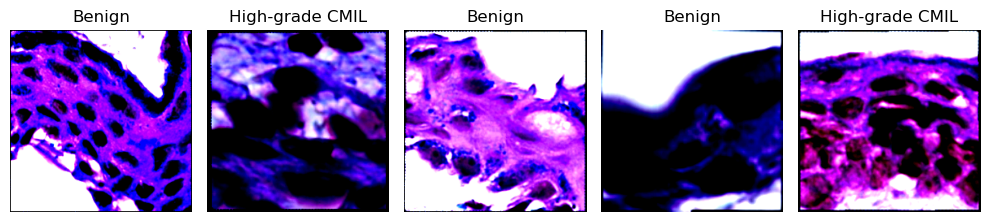

In [39]:
# # ---------------------------
# # Oversampling for class imbalance in training data
# # ---------------------------
# def oversample_dataset(dataset):
#     # Get all labels from the dataset
#     labels_list = [label for _, label in dataset]
    
#     # Initialize RandomOverSampler
#     oversampler = RandomOverSampler(random_state=42)
    
#     # Resample the dataset indices
#     resampled_indices, _ = oversampler.fit_resample(np.arange(len(dataset)).reshape(-1, 1), labels_list)
    
#     # Create new dataset list with oversampled indices
#     resampled_dataset = [dataset[i[0]] for i in resampled_indices]
#     return resampled_dataset

# train_dataset_resampled = oversample_dataset(train_dataset)

# ---------------------------
# Create DataLoaders for training, validation, and testing
# ---------------------------

#took out num_workers=os.cpu_count()
# No more oversampling — just use the raw training set
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ---------------------------
# Visualize a few training images
# ---------------------------
images, labels_batch = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels_batch[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [40]:
# ---------------------------
# Define checkpoint saving and loading functions
# ---------------------------
def save_checkpoint(model, optimizer, class_mapping, arch, epoch):
    """
    Save trained model weights along with optimizer state and epoch number.
    """
    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    }
    timestamp = datetime.now().date().strftime("%Y%m%d")
    checkpoint_path = os.path.join(checkpoint_dir, f"{timestamp}_{arch}_epoch{epoch}.pth")
    torch.save(checkpoint, checkpoint_path)

def load_checkpoint(filepath, model, optimizer=None):
    """
    Loads the checkpoint from `filepath` and updates the given model (and optimizer).
    
    Returns:
        model: The model with loaded state.
        optimizer (optional): The optimizer with loaded state if provided.
        start_epoch: The epoch number to resume training from.
    """
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer, start_epoch

In [41]:
# ---------------------------
# Define validation and training routines
# ---------------------------
def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    # Set model to evaluation mode
    model.eval()
    # Iterate over the validation data
    for images, labels in val_loader:
        # Transfer images and labels to the appropriate device
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        val_loss += criterion(output, labels).item()
        probabilities = torch.exp(output)
        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean().item()

    return val_loss, accuracy

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5, start_epoch=0):
    plot_training = []
    plot_validation = []

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0

        # Training loop
        for images, labels in train_loader:
            # Send images and labels to the designated device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        
        model.eval()
        with torch.no_grad():
            validation_loss, accuracy = validation(model, criterion, val_loader)
        avg_val_loss = validation_loss / len(val_loader)
        avg_val_acc  = accuracy / len(val_loader)
        print(f"Epoch: {e+1}/{epochs}  Training Loss: {epoch_loss:.3f}  Validation Loss: {avg_val_loss:.3f}  Validation Accuracy: {avg_val_acc:.3f}")

        plot_training.append(epoch_loss)
        plot_validation.append(avg_val_loss)

        # Save checkpoint at the end of the epoch
        class_mapping = {'Benign': 0, 'High-grade CMIL': 1}
        arch = "densenet121"
        save_checkpoint(model, optimizer, class_mapping, arch, epoch=e+1)

    plt.plot(range(len(plot_training)), plot_training, label='training')
    plt.plot(range(len(plot_validation)), plot_validation, label='validation')
    plt.legend()
    plt.show()

    return model

# ---------------------------
# Set device: mps if available, then cuda, else cpu
# ---------------------------
device = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() 
                      else "cpu")

In [42]:

# ---------------------------
# Set up the model using a pretrained DenseNet-121
# ---------------------------
num_classes = 2
model = models.densenet121(pretrained=True)

# # Freeze all parameters of DenseNet to avoid backpropagating through the entire network
# for parameter in model.parameters():
#     parameter.requires_grad = False

# # Customize the classifier
# num_ftrs = model.classifier.in_features
# classifier = nn.Sequential(OrderedDict([
#     ("fc", nn.Linear(num_ftrs, num_classes)),
#     ("output", nn.LogSoftmax(dim=1))
# ]))
# model.classifier = classifier
# model = model.to(device)

# print("\nModified final layer:")
# print(model.classifier)

# Build a custom classifier:
# Get the number of inputs from the DenseNet classifier
num_ftrs = model.classifier.in_features

# Replace the original classifier with a simple Linear layer.
# This is more standard when using CrossEntropyLoss, which expects raw logits.
model.classifier = nn.Linear(num_ftrs, num_classes)

# Move the model to the defined device (mps, cuda, or cpu)
model = model.to(device)

# For confirmation, print the modified classifier
print("\nModified final layer:")
print(model.classifier)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Modified final layer:
Linear(in_features=1024, out_features=2, bias=True)


In [43]:
# ---------------------------
# Define loss function and optimizer
# ---------------------------
# Use CrossEntropyLoss directly because it combines softmax and log operations.
criterion = nn.CrossEntropyLoss()

# Update the optimizer to include all model parameters, not just the classifier.
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: 1/5  Training Loss: 0.445  Validation Loss: 2.037  Validation Accuracy: 0.603
Epoch: 2/5  Training Loss: 0.307  Validation Loss: 1.312  Validation Accuracy: 0.562
Epoch: 3/5  Training Loss: 0.236  Validation Loss: 1.157  Validation Accuracy: 0.621
Epoch: 4/5  Training Loss: 0.257  Validation Loss: 0.990  Validation Accuracy: 0.657
Epoch: 5/5  Training Loss: 0.142  Validation Loss: 2.801  Validation Accuracy: 0.469


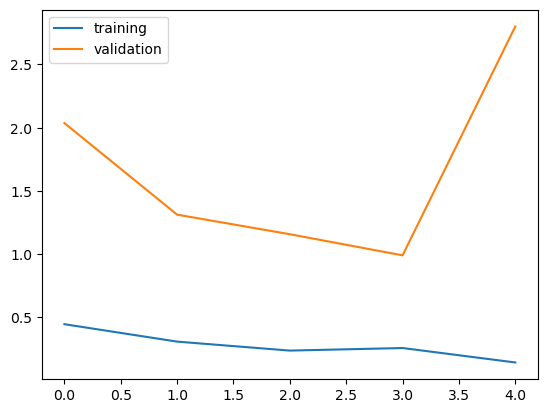

In [44]:
# ---------------------------
# Train the model
# ---------------------------
densenet_model = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5)

# If training was previously interrupted and a checkpoint exists,
# you can load the checkpoint as follows:
# checkpoint_path = os.path.join(checkpoint_dir, "20250415_densenet121_epoch1.pth")  # Update as needed
# model, optimizer, saved_epoch = load_checkpoint(checkpoint_path, model, optimizer)
# print(f"Resuming training from epoch {saved_epoch + 1}...")
# model = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5, start_epoch=saved_epoch)

In [45]:
# ---------------------------
# Evaluate the model on the test set
# ---------------------------
model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []

    for images, labels in test_loader:
        # Move images and labels to the device (cpu, cuda, or mps)
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        probabilities = torch.exp(output)
        predictions += probabilities.max(dim=1)[1].tolist()
        true_labels += labels.tolist()

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.26      0.51      0.34       170
           1       0.56      0.30      0.39       356

    accuracy                           0.37       526
   macro avg       0.41      0.40      0.36       526
weighted avg       0.46      0.37      0.37       526



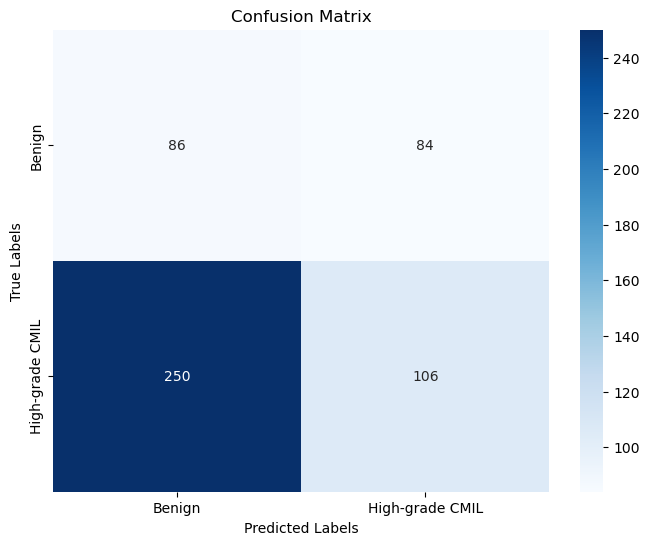

In [46]:
# ---------------------------
# Plot confusion matrix for the test results
# ---------------------------
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [47]:
# ---------------------------
# Get per-case accuracies in the test set
# ---------------------------
case_predictions = {}
case_true_labels = {}
case_accuracies = {}

# Create a mapping from image paths to their associated case number
image_to_case = {}
for case_num, patch_list in test_patches.items():
    for patch in patch_list:
        image_to_case[patch] = case_num

# Map predictions back to cases
for i in range(len(test_dataset)):
    # Retrieve image path and label; note that __getitem__ only returns the image tensor and label,
    # so we refer to test_dataset.image_paths to know which case each image comes from.
    _, label = test_dataset[i]
    img_path = test_dataset.image_paths[i]
    case_num = image_to_case[img_path]
    prediction = predictions[i]

    if case_num not in case_predictions:
        case_predictions[case_num] = []
        case_true_labels[case_num] = []
    case_predictions[case_num].append(prediction)
    case_true_labels[case_num].append(label)

for case_num, preds in case_predictions.items():
    correct_count = sum(1 for p, t in zip(preds, case_true_labels[case_num]) if p == t)
    accuracy = correct_count / len(preds) if len(preds) > 0 else 0
    case_accuracies[case_num] = accuracy

# Print per-case accuracies
for case_num, accuracy in case_accuracies.items():
    true_label = case_true_labels[case_num][0]  # Assumes all patches for a case share the same label
    true_label_name = 'Benign' if true_label == 0 else 'High-grade CMIL'
    print(f"Case {case_num}: Accuracy = {accuracy:.4f}, True Label = {true_label_name}")

Case 74: Accuracy = 0.9123, True Label = High-grade CMIL
Case 99: Accuracy = 0.4464, True Label = High-grade CMIL
Case 53: Accuracy = 0.6364, True Label = Benign
Case 76: Accuracy = 0.9286, True Label = Benign
Case 52: Accuracy = 0.3333, True Label = High-grade CMIL
Case 2: Accuracy = 0.4630, True Label = Benign
Case 82: Accuracy = 0.0685, True Label = High-grade CMIL
Case 56: Accuracy = 0.4324, True Label = Benign
Case 49: Accuracy = 0.8462, True Label = High-grade CMIL
Case 86: Accuracy = 0.0000, True Label = High-grade CMIL
